In [8]:
# Import Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import normaltest, chi2_contingency, mannwhitneyu, ttest_ind, kstest
import statsmodels.api as sm
import os
import missingno as msno

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
pd.set_option('display.max_colwidth', None)

In [9]:
# List of date columns for each Olist dataset
# This dictionary maps each dataset filename to a list of columns that should be parsed as dates.
date_cols = {
    'olist_orders_dataset.csv': [
        'order_purchase_timestamp',
        'order_approved_at',
        'order_delivered_carrier_date',
        'order_delivered_customer_date',
        'order_estimated_delivery_date',
    ],
    'olist_order_items_dataset.csv': [
        'shipping_limit_date',
    ],
    'olist_order_reviews_dataset.csv': [
        'review_creation_date',
        'review_answer_timestamp',
    ],
    # The following datasets have NO date columns:
    # 'olist_customers_dataset.csv'
    # 'olist_geolocation_dataset.csv'
    # 'olist_order_payments_dataset.csv'
    # 'olist_products_dataset.csv'
    # 'olist_sellers_dataset.csv'
    # 'product_category_name_translation.csv'
    'master_olist_dataset.csv': [
        'order_purchase_timestamp',
        'order_approved_at',
        'order_delivered_carrier_date',
        'order_delivered_customer_date',
        'order_estimated_delivery_date',
        'shipping_limit_date',
        'review_creation_date',
        'review_answer_timestamp',
    ]
}

def read_olist_csv(path):
    """
    Reads an Olist CSV and parses dates for the correct columns.
    Args:
        path (str): Path to the CSV file.
    Returns:
        pd.DataFrame: Loaded dataframe with date columns parsed as datetime.
    """
    # Extract just the filename, e.g., 'olist_orders_dataset.csv'
    filename = os.path.basename(path)
    # Get the correct date columns for this file, or an empty list
    parse_dates = date_cols.get(filename, [])
    # Read the CSV, parsing the specified date columns (if any)
    return pd.read_csv(path, parse_dates=parse_dates)

Load original (raw) datasets:

In [10]:
original_df_orders           = read_olist_csv('../data/original_data/olist_orders_dataset.csv')
original_df_customers        = read_olist_csv('../data/original_data/olist_customers_dataset.csv')
original_df_order_items      = read_olist_csv('../data/original_data/olist_order_items_dataset.csv')
original_df_order_payments   = read_olist_csv('../data/original_data/olist_order_payments_dataset.csv')
original_df_reviews          = read_olist_csv('../data/original_data/olist_order_reviews_dataset.csv')
original_df_products         = read_olist_csv('../data/original_data/olist_products_dataset.csv')
original_df_prod_cat_tr      = read_olist_csv('../data/original_data/product_category_name_translation.csv')
original_df_sellers          = read_olist_csv('../data/original_data/olist_sellers_dataset.csv')
original_df_geolocation      = read_olist_csv('../data/original_data/olist_geolocation_dataset.csv')

Load cleaned datasets

In [11]:
cleaned_delivered_df_orders           = read_olist_csv('../data/cleaned_data/olist_orders_dataset.csv')
cleaned_df_customers        = read_olist_csv('../data/cleaned_data/olist_customers_dataset.csv')
cleaned_delivered_df_order_items      = read_olist_csv('../data/cleaned_data/olist_order_items_dataset.csv')
cleaned_delivered_df_order_payments   = read_olist_csv('../data/cleaned_data/olist_order_payments_dataset.csv')
cleaned_delivered_df_reviews          = read_olist_csv('../data/cleaned_data/olist_order_reviews_dataset.csv')
cleaned_df_products         = read_olist_csv('../data/cleaned_data/olist_products_dataset.csv')
cleaned_df_prod_cat_tr      = read_olist_csv('../data/cleaned_data/product_category_name_translation.csv')
cleaned_df_sellers          = read_olist_csv('../data/cleaned_data/olist_sellers_dataset.csv')
cleaned_df_geolocation      = read_olist_csv('../data/cleaned_data/olist_geolocation_dataset.csv')

In [12]:
cleaned_delivered_df_order_items.shape

(109953, 7)

Load master dataset

In [13]:
master_olist_dataset = read_olist_csv('../data/cleaned_data/master_olist_dataset.csv')

In [14]:
master_olist_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109933 entries, 0 to 109932
Data columns (total 41 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       109933 non-null  object        
 1   customer_id                    109933 non-null  object        
 2   order_status                   109933 non-null  object        
 3   order_purchase_timestamp       109933 non-null  datetime64[ns]
 4   order_approved_at              109933 non-null  datetime64[ns]
 5   order_delivered_carrier_date   109933 non-null  datetime64[ns]
 6   order_delivered_customer_date  109933 non-null  datetime64[ns]
 7   order_estimated_delivery_date  109933 non-null  datetime64[ns]
 8   customer_unique_id             109933 non-null  object        
 9   customer_zip_code_prefix       109933 non-null  int64         
 10  customer_city                  109933 non-null  object        
 11  

In [15]:
master_olist_dataset.describe()

,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_zip_code_prefix,order_item_id,shipping_limit_date,price,freight_value,...,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,total_payment_value,n_payments,max_installments,review_score,review_answer_timestamp
count,109933,109933,109933,109933,109933,109933.000000,109933.000000,109933,109933.000000,109933.000000,...,109933.000000,109933.000000,109933.000000,109933.000000,109933.000000,109933.000000,109933.000000,109933.000000,108612.000000,108612
mean,2018-01-01 22:55:32.203014656,2018-01-02 09:27:31.801269760,2018-01-05 05:48:30.043553536,2018-01-14 10:30:51.894344704,2018-01-25 18:11:03.524146432,35142.813996,1.197839,2018-01-08 13:28:47.387499520,120.044161,19.949499,...,2090.464246,30.147417,16.556302,22.986192,24467.719320,179.509910,1.043918,3.014445,4.083757,2018-01-17 19:05:24.762466304
min,2016-10-03 09:44:50,2016-10-04 09:43:32,2016-10-08 10:34:01,2016-10-11 13:46:32,2016-10-27 00:00:00,1004.000000,1.000000,2016-10-08 10:34:01,0.850000,0.000000,...,0.000000,7.000000,2.000000,6.000000,1001.000000,9.590000,1.000000,0.000000,1.000000,2016-10-16 03:20:17
25%,2017-09-15 08:28:52,2017-09-15 14:25:19,2017-09-18 22:43:47,2017-09-26 20:24:02,2017-10-06 00:00:00,11250.000000,1.000000,2017-09-21 15:05:40,39.900000,13.080000,...,300.000000,18.000000,8.000000,15.000000,6429.000000,65.550000,1.000000,1.000000,4.000000,2017-09-30 22:56:09.249999872
50%,2018-01-20 20:47:34,2018-01-22 13:50:34,2018-01-24 17:41:57,2018-02-02 19:28:30,2018-02-16 00:00:00,24342.000000,1.000000,2018-01-26 16:59:44,74.900000,16.260000,...,700.000000,25.000000,13.000000,20.000000,13568.000000,114.340000,1.000000,2.000000,5.000000,2018-02-06 22:30:07
75%,2018-05-04 23:45:36,2018-05-05 13:33:24,2018-05-08 13:22:00,2018-05-15 18:21:55,2018-05-28 00:00:00,59063.000000,1.000000,2018-05-10 16:53:05,134.500000,21.150000,...,1800.000000,38.000000,20.000000,30.000000,27972.000000,194.910000,1.000000,4.000000,5.000000,2018-05-20 15:38:16.750000128
max,2018-08-29 15:00:37,2018-08-29 15:10:26,2018-09-11 19:48:28,2018-10-17 13:22:46,2018-10-25 00:00:00,99980.000000,21.000000,2020-04-09 22:35:08,6735.000000,409.680000,...,40425.000000,105.000000,105.000000,118.000000,99730.000000,13664.080000,26.000000,24.000000,5.000000,2018-10-29 12:27:35
std,NaN,NaN,NaN,NaN,NaN,29893.915025,0.706168,NaN,182.449223,15.701392,...,3743.079447,16.126370,13.410562,11.689901,27623.707529,271.586656,0.376679,2.800117,1.345483,NaN


In [16]:
# 4. Core delay & flag features
master_olist_dataset['is_late']    = master_olist_dataset['order_delivered_customer_date'] > master_olist_dataset['order_estimated_delivery_date']
master_olist_dataset['late_days']    = (master_olist_dataset['order_delivered_customer_date'] - master_olist_dataset['order_estimated_delivery_date']).dt.days
master_olist_dataset['dispatch_delay'] = (master_olist_dataset['order_delivered_carrier_date'] - master_olist_dataset['shipping_limit_date']).dt.days
master_olist_dataset['is_late_dispatch'] = (master_olist_dataset['dispatch_delay'] > 0)
master_olist_dataset['dispatch_time'] = (master_olist_dataset['order_delivered_carrier_date'] - master_olist_dataset['order_approved_at']).dt.days
master_olist_dataset['transit_time']  = (master_olist_dataset['order_delivered_customer_date']  - master_olist_dataset['order_delivered_carrier_date']).dt.days

# 5. Review bucket
master_olist_dataset['review_bucket'] = master_olist_dataset['review_score'].apply(lambda x: 'Good (4-5)' if x > 3 else 'Bad (1-3)')

In [17]:
master_olist_dataset.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,review_answer_timestamp,has_review,product_category_name_english,is_late,late_days,dispatch_delay,is_late_dispatch,dispatch_time,transit_time,review_bucket
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,2017-10-12 03:43:48,True,housewares,False,-8,-2,False,2,6,Good (4-5)
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,...,2018-08-08 18:37:50,True,perfumery,False,-6,-4,False,0,12,Good (4-5)
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,...,2018-08-22 19:07:58,True,auto,False,-18,-5,False,0,9,Good (4-5)
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,...,2017-12-05 19:21:58,True,pet_shop,False,-13,-2,False,3,9,Good (4-5)
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,...,2018-02-18 13:02:51,True,stationery,False,-10,-6,False,0,1,Good (4-5)


In [18]:
# 6. Customer repeat & first-order flags
master_olist_dataset = master_olist_dataset.sort_values(['customer_unique_id','order_purchase_timestamp'])
master_olist_dataset['order_rank']        = master_olist_dataset.groupby('customer_unique_id')['order_purchase_timestamp'] \
                              .rank(method='first')
master_olist_dataset['first_order_flag']  = master_olist_dataset['order_rank'] == 1

order_counts = master_olist_dataset.groupby('customer_unique_id')['order_id'].nunique()
master_olist_dataset['customer_repeat_flag'] = master_olist_dataset['customer_unique_id'].map(order_counts > 1)

master_olist_dataset.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,is_late,late_days,dispatch_delay,is_late_dispatch,dispatch_time,transit_time,review_bucket,order_rank,first_order_flag,customer_repeat_flag
58290,e22acc9c116caa3f2b7121bbb380d08e,fadbb3709178fc513abc1b2670aa1ad2,delivered,2018-05-10 10:56:27,2018-05-10 11:11:18,2018-05-12 08:18:00,2018-05-16 20:48:37,2018-05-21,0000366f3b9a7992bf8c76cfdf3221e2,7787,...,False,-5,-4,False,1,4,Good (4-5),1.0,True,False
81604,3594e05a005ac4d06a72673270ef9ec9,4cb282e167ae9234755102258dd52ee8,delivered,2018-05-07 11:11:27,2018-05-07 18:25:44,2018-05-09 12:18:00,2018-05-10 18:02:42,2018-05-15,0000b849f77a49e4a4ce2b2a4ca5be3f,6053,...,False,-5,-3,False,1,1,Good (4-5),1.0,True,False
29222,b33ec3b699337181488304f362a6b734,9b3932a6253894a02c1df9d19004239f,delivered,2017-03-10 21:05:03,2017-03-10 21:05:03,2017-03-13 12:58:30,2017-04-05 14:38:47,2017-04-07,0000f46a3911fa3c0805444483337064,88115,...,False,-2,-3,False,2,23,Bad (1-3),1.0,True,False
108856,41272756ecddd9a9ed0180413cc22fb6,914991f0c02ef0843c0e7010c819d642,delivered,2017-10-12 20:29:41,2017-10-12 20:49:17,2017-10-13 20:08:19,2017-11-01 21:23:05,2017-11-13,0000f6ccb0745a6a4b88665a16c9f078,66812,...,False,-12,-6,False,0,19,Good (4-5),1.0,True,False
45907,d957021f1127559cd947b62533f484f7,47227568b10f5f58a524a75507e6992c,delivered,2017-11-14 19:45:42,2017-11-14 20:06:52,2017-11-16 19:52:10,2017-11-27 23:08:56,2017-12-05,0004aac84e0df4da2b147fca70cf8255,18040,...,False,-8,-7,False,1,11,Good (4-5),1.0,True,False


In [19]:
# keep one row per customer’s first order
firsts = (master_olist_dataset[master_olist_dataset['first_order_flag']]
          .drop_duplicates('customer_unique_id'))

ret = (firsts.groupby('is_late')
       .agg(total_customers=('customer_unique_id','size'),
            repeat_customers=('customer_repeat_flag','sum'))
       .reset_index())
ret['repeat_rate'] = ret['repeat_customers'] / ret['total_customers']

rr_on_time = ret.loc[ret['is_late']==False, 'repeat_rate'].iloc[0]
rr_late    = ret.loc[ret['is_late']==True,  'repeat_rate'].iloc[0]
retention_delta = rr_on_time - rr_late

print(f"Retention on time first orders: {rr_on_time*100:.4f}%")
print(f"Retention late first orders: {rr_late*100:.4f}%")
print(f"Retention Δ (on-time vs late first orders): {retention_delta*100:.4f}%")

Retention on time first orders: 3.0413%
Retention late first orders: 2.5132%
Retention Δ (on-time vs late first orders): 0.5282%


In [22]:
# 8. Impact model: lost revenue from late first orders
late_first_count = ret.loc[ret['is_late']==True, 'total_customers'].iloc[0]
avg_order_value  = master_olist_dataset['total_payment_value'].mean()
lost_revenue     = retention_delta * late_first_count * avg_order_value

print(f"Estimated lost revenue from late first orders: {lost_revenue:,.2f}")

# 9. Seller- and state-level aggregates
seller_agg = master_olist_dataset.groupby('seller_id').agg(
    total_orders   = ('order_id','nunique'),
    late_orders    = ('is_late','sum'),
    late_rate      = ('is_late','mean'),
    avg_late_days  = ('late_days','mean'),
    avg_review_score = ('review_score', 'mean'),
    avg_payment_value = ('total_payment_value', 'mean'),
    late_dispatch_count = ('is_late_dispatch', 'sum'),
    late_dispatch_rate = ('is_late_dispatch', 'mean'),
    avg_dispatch_time = ('dispatch_time', 'mean'),
    avg_dispatch_delay = ('dispatch_delay', 'mean'),
).reset_index()

state_agg = master_olist_dataset.groupby('customer_state').agg(
    total_orders   = ('order_id','nunique'),
    late_orders    = ('is_late','sum'),
    late_rate      = ('is_late','mean'),
    avg_late_days  = ('late_days','mean'),
    avg_review_score = ('review_score', 'mean'),
    avg_payment_value = ('total_payment_value', 'mean'),
    late_dispatch_count = ('is_late_dispatch', 'sum'),
    late_dispatch_rate = ('is_late_dispatch', 'mean'),
    avg_dispatch_time = ('dispatch_time', 'mean'),
    avg_dispatch_delay = ('dispatch_delay', 'mean'),
).reset_index()

Estimated lost revenue from late first orders: 7,205.56


In [23]:
master_olist_dataset.shape

(109933, 51)

In [24]:
# 9. Merge location data
# Get median geo coordinates for each zip code
median_coords = cleaned_df_geolocation.groupby('geolocation_zip_code_prefix').agg({
    'geolocation_lat': 'median',
    'geolocation_lng': 'median'
}).reset_index()

# Merge customer geo data
master_olist_dataset = master_olist_dataset.merge(
    median_coords,
    left_on='customer_zip_code_prefix',
    right_on='geolocation_zip_code_prefix',
    how='left'
).rename(columns={
    'geolocation_lat': 'customer_lat',
    'geolocation_lng': 'customer_lng'
})

# Merge seller geo data 
master_olist_dataset = master_olist_dataset.merge(
    median_coords,
    left_on='seller_zip_code_prefix',
    right_on='geolocation_zip_code_prefix',
    how='left',
    suffixes=('_drop', '')
).rename(columns={
    'geolocation_lat': 'seller_lat',
    'geolocation_lng': 'seller_lng'
})

# Drop redundant columns
master_olist_dataset = master_olist_dataset.drop(columns=['geolocation_zip_code_prefix', 'geolocation_zip_code_prefix_drop'], errors='ignore')
master_olist_dataset.shape

(109933, 55)

In [25]:
# Check missing percentage for customer and seller coordinates
missing_coords = {
    'customer_lat': (master_olist_dataset['customer_lat'].isna().sum() / len(master_olist_dataset)) * 100,
    'customer_lng': (master_olist_dataset['customer_lng'].isna().sum() / len(master_olist_dataset)) * 100,
    'seller_lat': (master_olist_dataset['seller_lat'].isna().sum() / len(master_olist_dataset)) * 100,
    'seller_lng': (master_olist_dataset['seller_lng'].isna().sum() / len(master_olist_dataset)) * 100
}

# Create a DataFrame to display the missing percentages
missing_coords_df = pd.DataFrame({
    'Column': list(missing_coords.keys()),
    'Missing %': list(missing_coords.values())
})

# Calculate the number of rows with any missing coordinate
rows_with_missing = master_olist_dataset[
    master_olist_dataset['customer_lat'].isna() | 
    master_olist_dataset['customer_lng'].isna() | 
    master_olist_dataset['seller_lat'].isna() | 
    master_olist_dataset['seller_lng'].isna()
].shape[0]

# Calculate percentage of rows with any missing coordinate
pct_rows_with_missing = (rows_with_missing / len(master_olist_dataset)) * 100

# Display results
print(missing_coords_df)
print(f"\nRows with any missing coordinate: {rows_with_missing} ({pct_rows_with_missing:.2f}%)")

         Column  Missing %
0  customer_lat   0.262887
1  customer_lng   0.262887
2    seller_lat   0.226502
3    seller_lng   0.226502

Rows with any missing coordinate: 537 (0.49%)


In [26]:
# overall share of orders by state
overall_customer = (master_olist_dataset['customer_state']
           .value_counts(normalize=True)
           .rename('overall_customer_prop'))

overall_seller = (master_olist_dataset['seller_state']
          .value_counts(normalize=True)
          .rename('overall_seller_prop'))

# Create masks for missing coordinates
missing_customer_mask = master_olist_dataset['customer_lat'].isna()
missing_seller_mask = master_olist_dataset['seller_lat'].isna()

# Calculate proportion for missing customer coordinates by state
missing_customer_prop = (master_olist_dataset.loc[missing_customer_mask, 'customer_state']
                .value_counts(normalize=True)
                .rename('missing_customer_prop'))

# Calculate proportion for missing seller coordinates by state
missing_seller_prop = (master_olist_dataset.loc[missing_seller_mask, 'seller_state']
                .value_counts(normalize=True)
                .rename('missing_seller_prop'))

# Create a dataframe for customer bias analysis
customer_bias = (pd.concat([overall_customer, missing_customer_prop], axis=1)
                .fillna(0)
                .assign(customer_lift=lambda d: d['missing_customer_prop'] / d['overall_customer_prop']))

# Create a dataframe for seller bias analysis
seller_bias = (pd.concat([overall_seller, missing_seller_prop], axis=1)
                .fillna(0)
                .assign(seller_lift=lambda d: d['missing_seller_prop'] / d['overall_seller_prop']))

# Show the top 10 states with highest lift for customers
display(customer_bias.sort_values('customer_lift', ascending=False))

display(seller_bias.sort_values('seller_lift', ascending=False))

,overall_customer_prop,missing_customer_prop,customer_lift
customer_state,,,
DF,0.021386,0.619377,28.962139
RO,0.002483,0.006920,2.786747
PI,0.004721,0.010381,2.198792
CE,0.012962,0.020761,1.601646
GO,0.020658,0.031142,1.507494
RN,0.004739,0.006920,1.460234
MA,0.007250,0.010381,1.431836
PB,0.005331,0.006920,1.298263
BA,0.033466,0.041522,1.240743


,overall_seller_prop,missing_seller_prop,seller_lift
seller_state,,,
DF,0.008023,0.164659,20.523149
MG,0.078002,0.244980,3.140685
SP,0.713307,0.558233,0.782598
RS,0.019685,0.008032,0.408039
PR,0.077038,0.024096,0.312786
CE,0.000819,0.000000,0.000000
PA,0.000073,0.000000,0.000000
SE,0.000091,0.000000,0.000000
PI,0.000100,0.000000,0.000000


Only 0.5 % of orders lacked ZIP-level coordinates. Because 62 % of these came from Brasília (a compact metro area), we imputed missing lat/lng with the median of all geolocation points in the same state and flagged those rows. This retains all data while avoiding external APIs and introducing no target leakage.

- Only 0.26 % of customers and 0.23 % of sellers lack coordinates.
- \> 60 % of those gaps are in DF (Brasília)—a single, geographically small metro area.
- Remaining gaps are scattered, each contributing ≪ 0.05 % of total rows.	
- A single median point for DF is basically a city centroid (< 15 km error)—more precise than the entire state centroid would be in SP or MG.
- Errors elsewhere (SP, MG, etc.) affect < 0.1 % of rows, so any blurring is statistically negligible.

In [27]:
# build once
state_centroids = (cleaned_df_geolocation
                   .groupby('geolocation_state', as_index=False)
                   .agg(state_lat=('geolocation_lat', 'median'),
                        state_lng=('geolocation_lng', 'median')))

def impute_state_centroid(df, role):
    df = df.merge(state_centroids,
                  left_on=f'{role}_state',
                  right_on='geolocation_state',
                  how='left')
    mask = df[f'{role}_lat'].isna()
    df.loc[mask, f'{role}_lat'] = df.loc[mask, 'state_lat']
    df.loc[mask, f'{role}_lng'] = df.loc[mask, 'state_lng']
    df[f'{role}_coord_imputed'] = mask          # flag uncertainty
    return df.drop(columns=['state_lat', 'state_lng', 'geolocation_state'])

master_olist_dataset = impute_state_centroid(master_olist_dataset, 'customer')
master_olist_dataset = impute_state_centroid(master_olist_dataset, 'seller')

master_olist_dataset = master_olist_dataset.drop(columns=['customer_coord_imputed', 'seller_coord_imputed'], errors='ignore')

master_olist_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109933 entries, 0 to 109932
Data columns (total 55 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       109933 non-null  object        
 1   customer_id                    109933 non-null  object        
 2   order_status                   109933 non-null  object        
 3   order_purchase_timestamp       109933 non-null  datetime64[ns]
 4   order_approved_at              109933 non-null  datetime64[ns]
 5   order_delivered_carrier_date   109933 non-null  datetime64[ns]
 6   order_delivered_customer_date  109933 non-null  datetime64[ns]
 7   order_estimated_delivery_date  109933 non-null  datetime64[ns]
 8   customer_unique_id             109933 non-null  object        
 9   customer_zip_code_prefix       109933 non-null  int64         
 10  customer_city                  109933 non-null  object        
 11  

In [28]:
display(master_olist_dataset.head())

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,dispatch_time,transit_time,review_bucket,order_rank,first_order_flag,customer_repeat_flag,customer_lat,customer_lng,seller_lat,seller_lng
0,e22acc9c116caa3f2b7121bbb380d08e,fadbb3709178fc513abc1b2670aa1ad2,delivered,2018-05-10 10:56:27,2018-05-10 11:11:18,2018-05-12 08:18:00,2018-05-16 20:48:37,2018-05-21,0000366f3b9a7992bf8c76cfdf3221e2,7787,...,1,4,Good (4-5),1.0,True,False,-23.337558,-46.828132,-22.709287,-47.665524
1,3594e05a005ac4d06a72673270ef9ec9,4cb282e167ae9234755102258dd52ee8,delivered,2018-05-07 11:11:27,2018-05-07 18:25:44,2018-05-09 12:18:00,2018-05-10 18:02:42,2018-05-15,0000b849f77a49e4a4ce2b2a4ca5be3f,6053,...,1,1,Good (4-5),1.0,True,False,-23.557850,-46.788771,-23.491089,-46.583632
2,b33ec3b699337181488304f362a6b734,9b3932a6253894a02c1df9d19004239f,delivered,2017-03-10 21:05:03,2017-03-10 21:05:03,2017-03-13 12:58:30,2017-04-05 14:38:47,2017-04-07,0000f46a3911fa3c0805444483337064,88115,...,2,23,Bad (1-3),1.0,True,False,-27.543700,-48.635335,-23.211320,-46.762824
3,41272756ecddd9a9ed0180413cc22fb6,914991f0c02ef0843c0e7010c819d642,delivered,2017-10-12 20:29:41,2017-10-12 20:49:17,2017-10-13 20:08:19,2017-11-01 21:23:05,2017-11-13,0000f6ccb0745a6a4b88665a16c9f078,66812,...,0,19,Good (4-5),1.0,True,False,-1.307305,-48.481787,-23.542864,-46.490706
4,d957021f1127559cd947b62533f484f7,47227568b10f5f58a524a75507e6992c,delivered,2017-11-14 19:45:42,2017-11-14 20:06:52,2017-11-16 19:52:10,2017-11-27 23:08:56,2017-12-05,0004aac84e0df4da2b147fca70cf8255,18040,...,1,11,Good (4-5),1.0,True,False,-23.506028,-47.470332,-23.302839,-45.972729


In [29]:
# Calculate distance between customer and seller
# Using Haversine formula to calculate distance between two coordinates
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # Convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of earth in kilometers
    return c * r

# Apply the formula to calculate distance for all rows with valid coordinates
mask = (~master_olist_dataset['customer_lat'].isna()) & (~master_olist_dataset['seller_lat'].isna())
master_olist_dataset.loc[mask, 'distance_km'] = haversine(
    master_olist_dataset.loc[mask, 'customer_lat'],
    master_olist_dataset.loc[mask, 'customer_lng'],
    master_olist_dataset.loc[mask, 'seller_lat'],
    master_olist_dataset.loc[mask, 'seller_lng']
)

# Print summary statistics of the new distance feature
print(f"Distance statistics (km):")
print(f"Mean: {master_olist_dataset['distance_km'].mean():.2f}")
print(f"Median: {master_olist_dataset['distance_km'].median():.2f}")
print(f"Min: {master_olist_dataset['distance_km'].min():.2f}")
print(f"Max: {master_olist_dataset['distance_km'].max():.2f}")
print(f"Null values: {master_olist_dataset['distance_km'].isna().sum()}")

Distance statistics (km):
Mean: 596.77
Median: 433.35
Min: 0.00
Max: 3398.55
Null values: 0


In [30]:
# 10. Write outputs
master_olist_dataset.to_csv('../data/cleaned_data/master_olist_dataset_with_features.csv', index=False)
seller_agg.to_csv('../data/cleaned_data/seller_aggregation.csv', index=False)
state_agg.to_csv('../data/cleaned_data/state_aggregation.csv', index=False)

In [17]:
order_agg = (
    master_olist_dataset
      .groupby('order_id')
      .agg(order_late_flag=('is_late', 'max'))     # 1 if any item late
      .reset_index()
)

# merge back so Tableau has both item- and order-level flags
master_olist_dataset = master_olist_dataset.merge(order_agg[['order_id','order_late_flag']], on='order_id')

print(
    master_olist_dataset.groupby('order_late_flag')['order_id']
    .nunique()
    .rename('orders')
)

order_late_flag
False    88444
True      7822
Name: orders, dtype: int64


In [18]:
master_olist_dataset.isna().sum()

order_id                              0
customer_id                           0
order_status                          0
order_purchase_timestamp              0
order_approved_at                     0
order_delivered_carrier_date          0
order_delivered_customer_date         0
order_estimated_delivery_date         0
customer_unique_id                    0
customer_zip_code_prefix              0
customer_city                         0
customer_state                        0
order_item_id                         0
product_id                            0
seller_id                             0
shipping_limit_date                   0
price                                 0
freight_value                         0
product_category_name                 0
product_name_lenght                   0
product_description_lenght            0
product_photos_qty                    0
product_weight_g                      0
product_length_cm                     0
product_height_cm                     0


In [19]:
df = master_olist_dataset.copy()

In [20]:
import numpy as np
import pandas as pd

# --- PREP: Assume you already loaded the data as df ---
# df = pd.read_csv("master_olist_dataset_with_features.csv")

# If you have geolocation table, load it
# geo_df = pd.read_csv("geolocation.csv")

# --------- 1. SURE-FIRE FEATURES ---------
# 1. customer_state & seller_state
# Already present in the data

# 2. geo_distance_km and log_distance
# If you already have customer/seller lat/lng columns via zipcode prefix centroid mapping, use them directly.
def haversine_np(lat1, lon1, lat2, lon2):
    """
    Vectorized Haversine calculation for two arrays of lat/lon (degrees).
    Returns distance in kilometers.
    """
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return 6371 * c  # Earth radius in km

df["geo_distance_km"] = haversine_np(
    df["customer_lat"], df["customer_lng"],
    df["seller_lat"],   df["seller_lng"]
)

df["log_distance"] = np.log1p(df["geo_distance_km"])

# 3. same_state
df["same_state"] = (df["customer_state"] == df["seller_state"]).astype(int)

# 4. freight_value, price
# Already present; no action needed.

# 5. product_category_name_english
# Already present; no action needed.

# --------- 2. CANDIDATE FEATURES ---------
# 1. customer_is_remote (uses distance and freight_ratio thresholds)
# Create freight_ratio first
df["freight_ratio"] = df["freight_value"] / df["price"].clip(lower=1)
# 75th percentile distance, 95th percentile freight ratio
remote_dist_thr  = df["geo_distance_km"].quantile(0.75)
remote_freight_thr = df["freight_ratio"].quantile(0.95)
df["customer_is_remote"] = (
    (df["geo_distance_km"] > remote_dist_thr) |
    (df["freight_ratio"] > remote_freight_thr)
).astype(int)

# 2. seller_dispatch_hub (seller’s % of orders going out-of-state)
seller_home_state = df.groupby("seller_id")["seller_state"].first()
df = df.merge(seller_home_state.rename("seller_home_state"), on="seller_id", how="left")
df["is_outside_home"] = (df["customer_state"] != df["seller_home_state"]).astype(int)
seller_hub_score = (
    df.groupby("seller_id")["is_outside_home"]
    .agg(["sum", "count"])
    .assign(hub_score=lambda x: (x["sum"] + 2) / (x["count"] + 4))  # Laplace smoothing
)["hub_score"]
df["seller_dispatch_hub"] = df["seller_id"].map(seller_hub_score)

# 3. product_volume_cm3
dims = ["product_length_cm", "product_height_cm", "product_width_cm"]
df["product_volume_cm3"] = df[dims].prod(axis=1)

# 4. density_g_per_cm3
df["density_g_per_cm3"] = df["product_weight_g"] / df["product_volume_cm3"].clip(lower=1)

# 5. oversize_flag, overweight_flag (90th percentile in train only if possible)
vol_cut = df["product_volume_cm3"].quantile(0.90)
wgt_cut = df["product_weight_g"].quantile(0.90)
df["oversize_flag"] = (df["product_volume_cm3"] > vol_cut).astype(int)
df["overweight_flag"] = (df["product_weight_g"] > wgt_cut).astype(int)

# 6. inter_region (optional, for ablation)
# Define a mapping from state to macro-region (Brazilian standard)
brazil_region_map = {
    'AC':'North','AL':'Northeast','AP':'North','AM':'North','BA':'Northeast','CE':'Northeast',
    'DF':'Central-West','ES':'Southeast','GO':'Central-West','MA':'Northeast','MT':'Central-West',
    'MS':'Central-West','MG':'Southeast','PA':'North','PB':'Northeast','PR':'South','PE':'Northeast',
    'PI':'Northeast','RJ':'Southeast','RN':'Northeast','RS':'South','RO':'North','RR':'North',
    'SC':'South','SP':'Southeast','SE':'Northeast','TO':'North'
}
df["customer_region"] = df["customer_state"].map(brazil_region_map)
df["seller_region"]   = df["seller_state"].map(brazil_region_map)
df["inter_region"]    = (df["customer_region"] != df["seller_region"]).astype(int)

# --------- 3. CANCELLED FEATURES ---------
# product_category_name (PT): Drop – redundant with English version
# fragile_flag: Skip – high effort, low expected value
# price_per_item: Drop – at item level, it's just price

# --------- 4. CLEANUP AND FINAL FEATURE SET ---------
# List of all sure-fire and candidate columns for modeling
surefire_cols = [
    "customer_state", "seller_state", "geo_distance_km", "log_distance", "same_state",
    "freight_value", "price", "product_category_name_english"
]
candidate_cols = [
    "customer_is_remote", "seller_dispatch_hub", "product_volume_cm3", "density_g_per_cm3",
    "oversize_flag", "overweight_flag", "freight_ratio", "inter_region"
]

# OPTIONAL: drop intermediate/merge columns if not needed
df.drop(columns=["seller_home_state", "is_outside_home", "customer_region", "seller_region"], inplace=True, errors='ignore')

# Now you can select your feature set for modeling:
feature_cols = surefire_cols + candidate_cols

# Example: 
X = df[feature_cols]


In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Assume your features and target columns are named as below ---
feature_cols = [
    "customer_state", "seller_state", "geo_distance_km", "log_distance", "same_state",
    "freight_value", "price", "product_category_name_english",
    "customer_is_remote", "seller_dispatch_hub", "product_volume_cm3", "density_g_per_cm3",
    "oversize_flag", "overweight_flag", "freight_ratio", "inter_region"
]

# If not already numeric, select only numeric columns for corr
numeric_cols = df[feature_cols].select_dtypes(include=np.number).columns.tolist()
corrs = df[numeric_cols + ["is_late"]].corr(numeric_only=True)["is_late"].sort_values()
print("Features most positively correlated with lateness:")
display(corrs.tail(15))
print("\nFeatures most negatively correlated with lateness:")
display(corrs.head(15))


Features most positively correlated with lateness:


same_state            -0.054257
seller_dispatch_hub   -0.024556
density_g_per_cm3      0.004251
overweight_flag        0.013269
freight_ratio          0.014486
oversize_flag          0.016247
product_volume_cm3     0.017321
price                  0.021672
inter_region           0.022625
freight_value          0.040395
customer_is_remote     0.047362
log_distance           0.049811
geo_distance_km        0.068523
is_late                1.000000
Name: is_late, dtype: float64


Features most negatively correlated with lateness:


same_state            -0.054257
seller_dispatch_hub   -0.024556
density_g_per_cm3      0.004251
overweight_flag        0.013269
freight_ratio          0.014486
oversize_flag          0.016247
product_volume_cm3     0.017321
price                  0.021672
inter_region           0.022625
freight_value          0.040395
customer_is_remote     0.047362
log_distance           0.049811
geo_distance_km        0.068523
is_late                1.000000
Name: is_late, dtype: float64

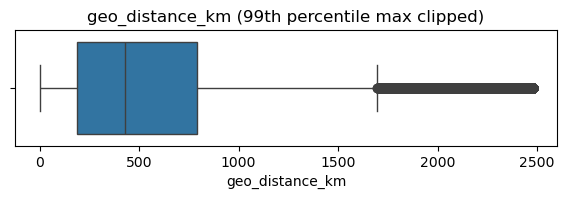

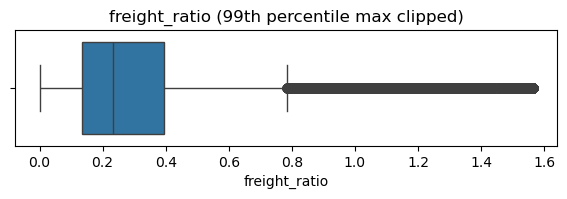

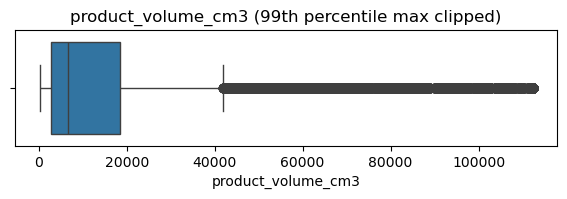

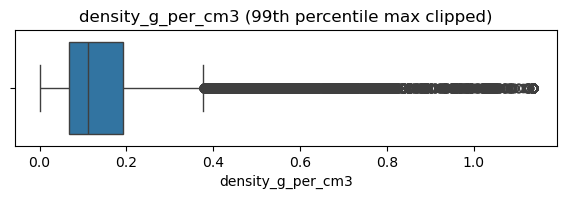

In [22]:
# Boxplots for main numeric features (clip to 99th pct for clarity)
for col in ["geo_distance_km", "freight_ratio", "product_volume_cm3", "density_g_per_cm3"]:
    plt.figure(figsize=(7,1.5))
    sns.boxplot(x=df[col].clip(upper=df[col].quantile(0.99)))
    plt.title(f"{col} (99th percentile max clipped)")
    plt.show()

In [ ]:
# # 10. Write outputs
# master_olist_dataset.to_csv('../data/cleaned_data/master_olist_dataset_with_features.csv', index=False)
# seller_agg.to_csv('../data/cleaned_data/seller_aggregation.csv', index=False)
# state_agg.to_csv('../data/cleaned_data/state_aggregation.csv', index=False)

In [ ]:
# master_olist_dataset_with_features = master_olist_dataset.copy()


In [ ]:
# master_olist_dataset = read_olist_csv('../data/cleaned_data/test_master_olist_dataset.csv')

In [ ]:
# # Filter datasets for orders delivered in 2018 only
# mask_2018_with_features = master_olist_dataset_with_features['order_delivered_customer_date'].dt.year == 2018
# orders_2018_with_features = master_olist_dataset_with_features[mask_2018_with_features]

# mask_2018_original = master_olist_dataset['order_delivered_customer_date'].dt.year == 2018
# orders_2018_original = master_olist_dataset[mask_2018_original]

# # Calculate is_late flag for the original dataset if not already present
# if 'is_late' not in master_olist_dataset.columns:
#     orders_2018_original['is_late'] = orders_2018_original['order_delivered_customer_date'] > orders_2018_original['order_estimated_delivery_date']

# # Calculate OTD rate at order level (not item level)
# # First, deduplicate by order_id to ensure each order is counted only once
# unique_orders_2018_with_features = orders_2018_with_features.drop_duplicates('order_id')
# unique_orders_2018_original = orders_2018_original.drop_duplicates('order_id')

# # Calculate OTD Rate for 2018 orders at order level
# otd_rate_2018_with_features = (1 - unique_orders_2018_with_features['is_late'].mean()) * 100
# otd_rate_2018_original = (1 - unique_orders_2018_original['is_late'].mean()) * 100

# # Print results
# print(f"2018 On-Time Delivery Rate (order level): {otd_rate_2018_with_features:.2f}%")
# print(f"2018 On-Time Delivery Rate (original dataset): {otd_rate_2018_original:.2f}%")

# # Count of orders from 2018
# print(f"\nTotal orders in 2018: {len(unique_orders_2018_with_features)}")
# print(f"Late orders in 2018: {unique_orders_2018_with_features['is_late'].sum()}")
# print(f"On-time orders in 2018: {(~unique_orders_2018_with_features['is_late']).sum()}")

# # Monthly trend for 2018
# monthly_otd = unique_orders_2018_with_features.groupby(
#     unique_orders_2018_with_features['order_delivered_customer_date'].dt.month
# ).agg(
#     total_orders=('order_id', 'count'),
#     late_orders=('is_late', 'sum'),
#     otd_rate=('is_late', lambda x: (1 - x.mean()) * 100)
# ).reset_index()
# monthly_otd.rename(columns={'order_delivered_customer_date': 'month'}, inplace=True)

# # Sort by month for better readability
# monthly_otd = monthly_otd.sort_values('month')

# print("\nMonthly OTD Rate for 2018:")
# for _, row in monthly_otd.iterrows():
#     month_name = {
#         1: 'January', 2: 'February', 3: 'March', 4: 'April',
#         5: 'May', 6: 'June', 7: 'July', 8: 'August', 
#         9: 'September', 10: 'October', 11: 'November', 12: 'December'
#     }.get(int(row['month']), f'Month {int(row["month"])}')
    
#     print(f"{month_name}: {row['otd_rate']:.2f}% ({row['total_orders']} orders, {row['late_orders']} late)")

2018 On-Time Delivery Rate (order level): 89.71%
2018 On-Time Delivery Rate (original dataset): 89.71%

Total orders in 2018: 55108
Late orders in 2018: 5672
On-time orders in 2018: 49436

Monthly OTD Rate for 2018:
January: 89.89% (6597.0 orders, 667.0 late)
February: 93.44% (5850.0 orders, 384.0 late)
March: 84.17% (6824.0 orders, 1080.0 late)
April: 81.37% (7849.0 orders, 1462.0 late)
May: 93.37% (7084.0 orders, 470.0 late)
June: 91.50% (6786.0 orders, 577.0 late)
July: 98.31% (5800.0 orders, 98.0 late)
August: 89.41% (8259.0 orders, 875.0 late)
September: 0.00% (56.0 orders, 56.0 late)
October: 0.00% (3.0 orders, 3.0 late)


C:\Users\User\AppData\Local\Temp\ipykernel_16020\4270926978.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_2018_original['is_late'] = orders_2018_original['order_delivered_customer_date'] > orders_2018_original['order_estimated_delivery_date']


In [54]:
order_late_flag = master_olist_dataset_with_features.groupby('order_id')['is_late'].max()
otdr_2018 = 1 - order_late_flag[master_olist_dataset_with_features.groupby('order_id')['order_delivered_customer_date'].max().dt.year == 2018].mean()
print(otdr_2018)

0.8970748348697104
